In [4]:
import numpy as np
import os
import hoomd
import gsd
import rowan
import pickle
from cmeutils.visualize import FresnelGSD

In [13]:
n_rigids = 2
rel_const_pos = np.load('rel_const_pos.npy')
with open('pps_ff.pkl', 'rb') as f:
    pps_ff = pickle.load(f)

In [14]:
gsd_dir = 'arrangement_snapshots'
if not os.path.exists(gsd_dir):
    os.mkdir(gsd_dir)

In [17]:
def create_rigid_simulation(orientations, positions, n_rigids, rel_const_pos, pps_ff):
    rigid_simulation = hoomd.Simulation(device=hoomd.device.auto_select(), seed=1)
    rigid_simulation.create_state_from_gsd(filename='rigid_init_{}.gsd'.format(n_rigids))
    const_particle_types = ['ca', 'ca', 'ca', 'ca', 'sh', 'ca', 'ca']
    

    rigid = hoomd.md.constrain.Rigid()
    rigid.body['rigid'] = {
        "constituent_types":const_particle_types,
        "positions": rel_const_pos,
        "orientations": [(1.0, 0.0, 0.0, 0.0)]* len(rel_const_pos),
        }
    integrator = hoomd.md.Integrator(dt=0.005, integrate_rotational_dof=True)
    rigid_simulation.operations.integrator = integrator
    integrator.rigid = rigid
    rigid_centers_and_free = hoomd.filter.Rigid(("center", "free"))
    nvt = hoomd.md.methods.ConstantVolume(
        filter=rigid_centers_and_free,
        thermostat=hoomd.md.methods.thermostats.Bussi(kT=1.0))
    integrator.methods.append(nvt)
    
    cell = hoomd.md.nlist.Cell(buffer=0, exclusions=['body'])
    
    lj = hoomd.md.pair.LJ(nlist=cell)
    
    # use aa pps simulation to define lj and special lj forces between constituent particles
    for k, v in dict(pps_ff[0].params).items():
        lj.params[k] = v
        lj.r_cut[k] = 4.8
    
    lj.params[('rigid', ['rigid', 'ca', 'sh'])]= dict(epsilon=0, sigma=0)
    lj.r_cut[('rigid', ['rigid', 'ca', 'sh'])] = 0

    integrator.forces.append(lj)
    rigid_simulation.state.thermalize_particle_momenta(filter=rigid_centers_and_free,
                                             kT=1.0)
    thermodynamic_quantities = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())

    rigid_simulation.operations.computes.append(thermodynamic_quantities)
    with rigid_simulation._state.cpu_local_snapshot as data:
        rtag = data.particles.rtag
        rigid_tags = rtag[:n_rigids]
        data.particles.orientation[rigid_tags] = orientations
        
        data.particles.position[rigid_tags] = positions

    rigid_simulation.run(0)
    return rigid_simulation

    


In [19]:
def rotate_quaternion(q, theta, axis):
    cos_theta_2 = np.cos(theta / 2)
    sin_theta_2 = np.sin(theta / 2)

    if axis == 'x':
        r = [cos_theta_2, sin_theta_2, 0, 0]
    elif axis == 'y':
        r = [cos_theta_2, 0, sin_theta_2, 0]
    elif axis == 'z':
        r = [cos_theta_2, 0, 0, sin_theta_2]
    else:
        raise ValueError("Axis must be 'x', 'y', or 'z'")

    q0, q1, q2, q3 = q
    r0, r1, r2, r3 = r

    q_prime = [
        r0 * q0 - r1 * q1 - r2 * q2 - r3 * q3,
        r0 * q1 + r1 * q0 + r2 * q3 - r3 * q2,
        r0 * q2 - r1 * q3 + r2 * q0 + r3 * q1,
        r0 * q3 + r1 * q2 - r2 * q1 + r3 * q0
    ]

    return q_prime


## Proxies for relative orientations

## Case 1 : parallel along Z axis

In [8]:
q0 = [1, 0, 0, 0]
rigid_pos = np.asarray([[0, 0, 2], [0, 0, -2]])
rigid_simulation = create_rigid_simulation(orientations=[q0, q0], positions=rigid_pos, n_rigids=n_rigids, 
                                           rel_const_pos=rel_const_pos, pps_ff=pps_ff)
hoomd.write.GSD.write(rigid_simulation.state, filename=f"{/q0_q0.gsd")

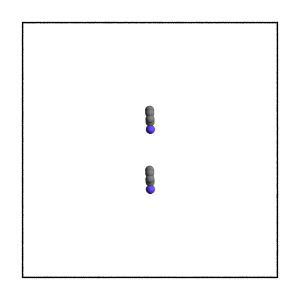

In [9]:
sim_viewer = FresnelGSD(gsd_file="new_snapshots/q0_q0.gsd", view_axis=(1, 0., 0), frame=-1, height=20,
                       color_dict={"sh": (0.42,0.267,1), "ca":(0.5, 0.5, 0.5), "rigid":(0.1, 0.8, 0.)}
                    )
sim_viewer.view()

### Case 2: q1=[0, 1, 0, 0], rot 180 around x

In [10]:
q1 = rotate_quaternion(q=q0, theta=np.pi, axis='x')
rigid_pos = [[0, 0, 2], [0, 0, -2]]
rigid_simulation = create_rigid_simulation(orientations=[q1, q1], positions=rigid_pos, 
                                           n_rigids=n_rigids, rel_const_pos=rel_const_pos, pps_ff=pps_ff)

hoomd.write.GSD.write(rigid_simulation.state, filename="new_snapshots/q1_q1.gsd")

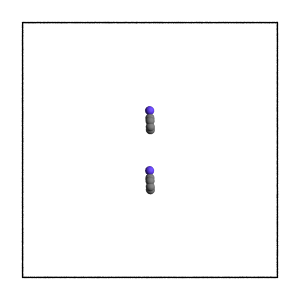

In [11]:
sim_viewer = FresnelGSD(gsd_file="new_snapshots/q1_q1.gsd", view_axis=(1, 0., 0), frame=-1, height=20,
                       color_dict={"sh": (0.42,0.267,1), "ca":(0.5, 0.5, 0.5), "rigid":(0.1, 0.8, 0.)}
                    )
sim_viewer.view()

## Case 3: rot 90 degress around y

In [12]:
rotate_quaternion(q=q0, theta=np.pi/2, axis='y')

array([0.70710678, 0.        , 0.70710678, 0.        ])

In [15]:
q2 = rotate_quaternion(q=q0, theta=np.pi/2, axis='y')
rigid_pos = [[0, 0, 2], [0, 0, -2]]
rigid_simulation = create_rigid_simulation(orientations=[q2, q2], positions=rigid_pos,
                                           n_rigids=n_rigids, rel_const_pos=rel_const_pos,
                                          pps_ff=pps_ff)

hoomd.write.GSD.write(rigid_simulation.state, filename="new_snapshots/q2_q2.gsd")

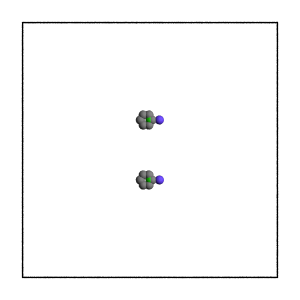

In [79]:
sim_viewer = FresnelGSD(gsd_file="new_snapshots/q2_q2.gsd", view_axis=(0, 1., 0), frame=-1, height=20,
                       color_dict={"sh": (0.42,0.267,1), "ca":(0.5, 0.5, 0.5), "rigid":(0.1, 0.8, 0.)}
                    )
sim_viewer.view()

### Case 4: rotate 90 degress around z axis

In [17]:
q3 = rotate_quaternion(q=q0, theta=np.pi/2 , axis="z")
rigid_pos = [[0, 0, 2], [0, 0, -2]]
rigid_simulation = create_rigid_simulation(orientations=[q3, q3], positions=rigid_pos,
                                           n_rigids=n_rigids, rel_const_pos=rel_const_pos,
                                          pps_ff=pps_ff)

hoomd.write.GSD.write(rigid_simulation.state, filename="new_snapshots/q3_q3.gsd")

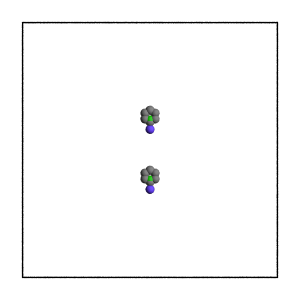

In [18]:
sim_viewer = FresnelGSD(gsd_file="new_snapshots/q3_q3.gsd", view_axis=(1, 0., 0), frame=-1, height=20,
                       color_dict={"sh": (0.42,0.267,1), "ca":(0.5, 0.5, 0.5), "rigid":(0.1, 0.8, 0.)}
                    )
sim_viewer.view()

## Ellipsoid Arrangmenets (with constant center-to-center distance R=2.)

In [11]:
rigid_pos = [[-1.0, 0, 0], [1.0, 0, 0]]

### 1. side-to-side with S aligned

potential_energy:  -0.9371754406724231


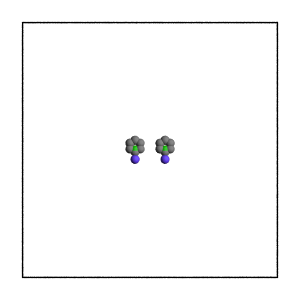

In [18]:
q1 = [1, 0, 0, 0]
q2= [1, 0, 0,0]
rigid_simulation = create_rigid_simulation(orientations=[q1, q2], positions=rigid_pos,
                                           n_rigids=n_rigids, rel_const_pos=rel_const_pos,
                                          pps_ff=pps_ff)
print('potential_energy: ', rigid_simulation.operations.computes[0].potential_energy)
hoomd.write.GSD.write(rigid_simulation.state, filename=f"{gsd_dir}/side-side-s-aligned.gsd")
# looking down the y axis
sim_viewer = FresnelGSD(gsd_file="new_snapshots/side-side-s-aligned.gsd", view_axis=(0, 1, 0), frame=-1, height=20,
                       color_dict={"sh": (0.42,0.267,1), "ca":(0.5, 0.5, 0.5), "rigid":(0.1, 0.8, 0.)}
                    )
sim_viewer.view()

### 2. side-to-side with S opposite

potential_energy:  -0.9015600035318423


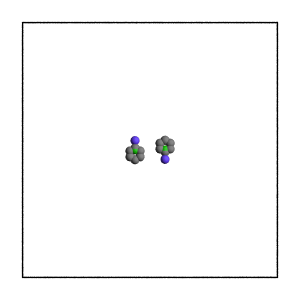

In [20]:
q1 = [1, 0, 0, 0]
q2= rotate_quaternion(q1, theta=np.pi, axis='x')
rigid_simulation = create_rigid_simulation(orientations=[q1, q2], positions=rigid_pos,
                                           n_rigids=n_rigids, rel_const_pos=rel_const_pos,
                                          pps_ff=pps_ff)
print('potential_energy: ', rigid_simulation.operations.computes[0].potential_energy)
hoomd.write.GSD.write(rigid_simulation.state, filename="new_snapshots/side-side-s-opposite.gsd")
# looking down the y axis
sim_viewer = FresnelGSD(gsd_file="new_snapshots/side-side-s-opposite.gsd", view_axis=(0, 1, 0), frame=-1, height=20,
                       color_dict={"sh": (0.42,0.267,1), "ca":(0.5, 0.5, 0.5), "rigid":(0.1, 0.8, 0.)}
                    )
sim_viewer.view()


### 3. face-to-face S aligned

potential_energy:  -0.5002767851660119


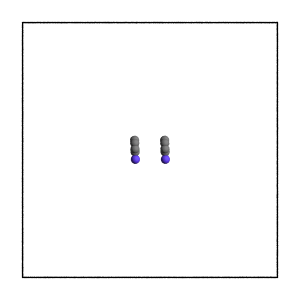

In [21]:
q1 = rotate_quaternion([1, 0, 0, 0], theta=np.pi/2, axis='z')
q2= rotate_quaternion([1, 0, 0, 0], theta=np.pi/2, axis='z')
rigid_simulation = create_rigid_simulation(orientations=[q1, q2], positions=rigid_pos,
                                           n_rigids=n_rigids, rel_const_pos=rel_const_pos,
                                          pps_ff=pps_ff)
print('potential_energy: ', rigid_simulation.operations.computes[0].potential_energy)
hoomd.write.GSD.write(rigid_simulation.state, filename="new_snapshots/face-face-s-aligned.gsd")
# looking down the y axis
sim_viewer = FresnelGSD(gsd_file="new_snapshots/face-face-s-aligned.gsd", view_axis=(0, 1, 0), frame=-1, height=20,
                       color_dict={"sh": (0.42,0.267,1), "ca":(0.5, 0.5, 0.5), "rigid":(0.1, 0.8, 0.)}
                    )
sim_viewer.view()

### 4. face-to-face S opposite

potential_energy:  -0.5006553758683023


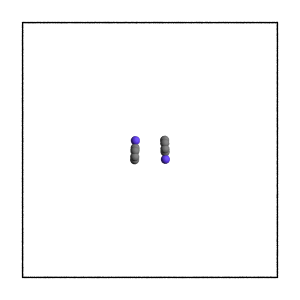

In [22]:
q1 = rotate_quaternion([1, 0, 0, 0], theta=np.pi/2, axis='z')
q2= rotate_quaternion(q1, theta=np.pi, axis='x')
rigid_simulation = create_rigid_simulation(orientations=[q1, q2], positions=rigid_pos,
                                           n_rigids=n_rigids, rel_const_pos=rel_const_pos,
                                          pps_ff=pps_ff)
print('potential_energy: ', rigid_simulation.operations.computes[0].potential_energy)
hoomd.write.GSD.write(rigid_simulation.state, filename="new_snapshots/face-face-s-opposite.gsd")
# looking down the y axis
sim_viewer = FresnelGSD(gsd_file="new_snapshots/face-face-s-opposite.gsd", view_axis=(0, 1, 0), frame=-1, height=20,
                       color_dict={"sh": (0.42,0.267,1), "ca":(0.5, 0.5, 0.5), "rigid":(0.1, 0.8, 0.)}
                    )
sim_viewer.view()

### 5. side-to-face s aligned

potential_energy:  -0.657896875435259


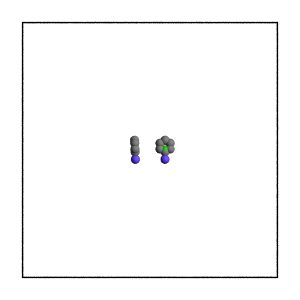

In [23]:
q1 = [1, 0, 0, 0]
q2= rotate_quaternion(q1, theta=np.pi/2, axis='z')
rigid_simulation = create_rigid_simulation(orientations=[q1, q2], positions=rigid_pos,
                                           n_rigids=n_rigids, rel_const_pos=rel_const_pos,
                                          pps_ff=pps_ff)
print('potential_energy: ', rigid_simulation.operations.computes[0].potential_energy)
hoomd.write.GSD.write(rigid_simulation.state, filename="new_snapshots/side-face-s-aligned.gsd")
# looking down the y axis
sim_viewer = FresnelGSD(gsd_file="new_snapshots/side-face-s-aligned.gsd", view_axis=(0, 1, 0), frame=-1, height=20,
                       color_dict={"sh": (0.42,0.267,1), "ca":(0.5, 0.5, 0.5), "rigid":(0.1, 0.8, 0.)}
                    )
sim_viewer.view()

### 5. side-to-face s opposite

potential_energy:  -0.6637701849491355


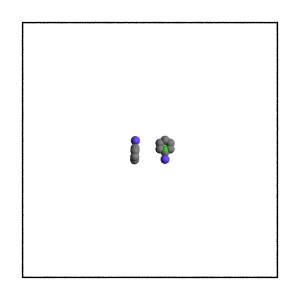

In [24]:
q1 = [1, 0, 0, 0]
q2= rotate_quaternion(rotate_quaternion(q1, theta=np.pi/2, axis='z'), theta=np.pi, axis='x')
rigid_simulation = create_rigid_simulation(orientations=[q1, q2], positions=rigid_pos,
                                           n_rigids=n_rigids, rel_const_pos=rel_const_pos,
                                          pps_ff=pps_ff)
print('potential_energy: ', rigid_simulation.operations.computes[0].potential_energy)
hoomd.write.GSD.write(rigid_simulation.state, filename="new_snapshots/side-face-s-opposite.gsd")
# looking down the y axis
sim_viewer = FresnelGSD(gsd_file="new_snapshots/side-face-s-opposite.gsd", view_axis=(0, 1, 0), frame=-1, height=20,
                       color_dict={"sh": (0.42,0.267,1), "ca":(0.5, 0.5, 0.5), "rigid":(0.1, 0.8, 0.)}
                    )
sim_viewer.view()

### 6. end-to-end s aligned

potential_energy:  56.08248024890145


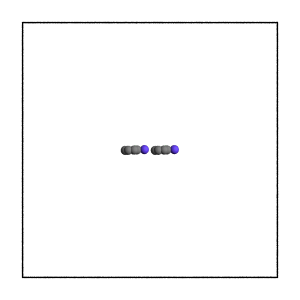

In [25]:
q1 = rotate_quaternion(rotate_quaternion(q=[1, 0, 0, 0], theta=np.pi/2, axis='y'), theta=np.pi/2, axis='x')
q2= q1
rigid_simulation = create_rigid_simulation(orientations=[q1, q2], positions=rigid_pos,
                                           n_rigids=n_rigids, rel_const_pos=rel_const_pos,
                                          pps_ff=pps_ff)
print('potential_energy: ', rigid_simulation.operations.computes[0].potential_energy)
hoomd.write.GSD.write(rigid_simulation.state, filename="new_snapshots/end-end-s-aligned.gsd")
# looking down the y axis
sim_viewer = FresnelGSD(gsd_file="new_snapshots/end-end-s-aligned.gsd", view_axis=(0, 1, 0), frame=-1, height=20,
                       color_dict={"sh": (0.42,0.267,1), "ca":(0.5, 0.5, 0.5), "rigid":(0.1, 0.8, 0.)}
                    )
sim_viewer.view()

### 7. end-to-end s opposite

potential_energy:  33.641014283196526


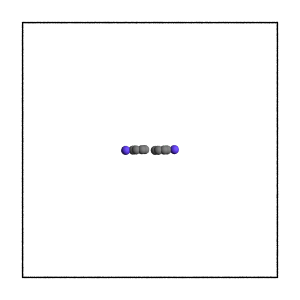

In [26]:
q1 = rotate_quaternion(rotate_quaternion(q=[1, 0, 0, 0], theta=np.pi/2, axis='y'), theta=np.pi/2, axis='x')
q2= rotate_quaternion(q1, theta=np.pi, axis='y')
rigid_simulation = create_rigid_simulation(orientations=[q1, q2], positions=rigid_pos,
                                           n_rigids=n_rigids, rel_const_pos=rel_const_pos,
                                          pps_ff=pps_ff)
print('potential_energy: ', rigid_simulation.operations.computes[0].potential_energy)
hoomd.write.GSD.write(rigid_simulation.state, filename="new_snapshots/end-end-s-opposite.gsd")
# looking down the y axis
sim_viewer = FresnelGSD(gsd_file="new_snapshots/end-end-s-opposite.gsd", view_axis=(0, 1, 0), frame=-1, height=20,
                       color_dict={"sh": (0.42,0.267,1), "ca":(0.5, 0.5, 0.5), "rigid":(0.1, 0.8, 0.)}
                    )
sim_viewer.view()

### 8. end-to-end s close

potential_energy:  93.65056948899937


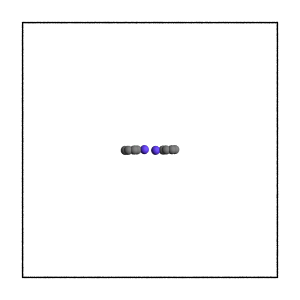

In [27]:
q2= rotate_quaternion(rotate_quaternion(q=[1, 0, 0, 0], theta=np.pi/2, axis='y'), theta=np.pi/2, axis='x')
q1 =  rotate_quaternion(q2, theta=np.pi, axis='y')
rigid_simulation = create_rigid_simulation(orientations=[q1, q2], positions=rigid_pos,
                                           n_rigids=n_rigids, rel_const_pos=rel_const_pos,
                                          pps_ff=pps_ff)
print('potential_energy: ', rigid_simulation.operations.computes[0].potential_energy)
hoomd.write.GSD.write(rigid_simulation.state, filename="new_snapshots/end-end-s-close.gsd")
# looking down the y axis
sim_viewer = FresnelGSD(gsd_file="new_snapshots/end-end-s-close.gsd", view_axis=(0, 1, 0), frame=-1, height=20,
                       color_dict={"sh": (0.42,0.267,1), "ca":(0.5, 0.5, 0.5), "rigid":(0.1, 0.8, 0.)}
                    )
sim_viewer.view()

### 9. side-to-end s far

potential_energy:  -1.5810203297767869


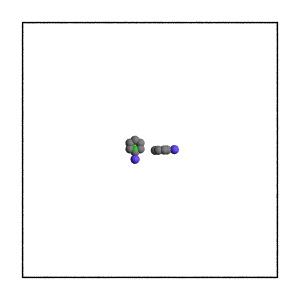

In [28]:
q1 = rotate_quaternion(rotate_quaternion(q=[1, 0, 0, 0], theta=np.pi/2, axis='y'), theta=np.pi/2, axis='x')
q2= [1, 0, 0, 0]
rigid_simulation = create_rigid_simulation(orientations=[q1, q2], positions=rigid_pos,
                                           n_rigids=n_rigids, rel_const_pos=rel_const_pos,
                                          pps_ff=pps_ff)
print('potential_energy: ', rigid_simulation.operations.computes[0].potential_energy)
hoomd.write.GSD.write(rigid_simulation.state, filename="new_snapshots/side-end-s-far.gsd")
# looking down the y axis
sim_viewer = FresnelGSD(gsd_file="new_snapshots/side-end-s-far.gsd", view_axis=(0, 1, 0), frame=-1, height=20,
                       color_dict={"sh": (0.42,0.267,1), "ca":(0.5, 0.5, 0.5), "rigid":(0.1, 0.8, 0.)}
                    )
sim_viewer.view()

### 10. side-to-end s close

potential_energy:  -1.7724649837669426


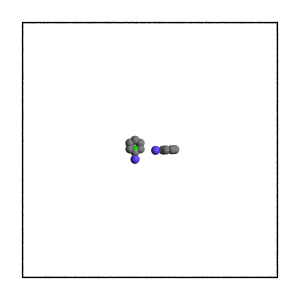

In [98]:
q1 = rotate_quaternion(rotate_quaternion(q=[1, 0, 0, 0], theta=np.pi/2, axis='y'), theta=np.pi/2, axis='x')
q1 = rotate_quaternion(q1, theta=np.pi, axis='y')
q2= [1, 0, 0, 0]
rigid_simulation = create_rigid_simulation(orientations=[q1, q2], positions=rigid_pos,
                                           n_rigids=n_rigids, rel_const_pos=rel_const_pos,
                                          pps_ff=pps_ff)
print('potential_energy: ', rigid_simulation.operations.computes[0].potential_energy)
hoomd.write.GSD.write(rigid_simulation.state, filename="new_snapshots/side-end-s-close.gsd")
# looking down the y axis
sim_viewer = FresnelGSD(gsd_file="new_snapshots/side-end-s-close.gsd", view_axis=(0, 1, 0), frame=-1, height=20,
                       color_dict={"sh": (0.42,0.267,1), "ca":(0.5, 0.5, 0.5), "rigid":(0.1, 0.8, 0.)}
                    )
sim_viewer.view()

### 11. face-to-end s far

potential_energy:  -1.2407235246024881


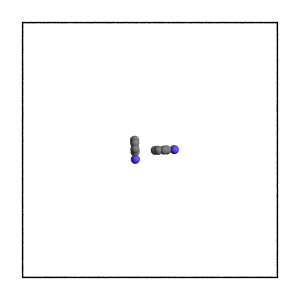

In [100]:
q1 = rotate_quaternion(rotate_quaternion(q=[1, 0, 0, 0], theta=np.pi/2, axis='y'), theta=np.pi/2, axis='x')
q2=  rotate_quaternion([1, 0, 0, 0], theta=np.pi/2, axis='z')
rigid_simulation = create_rigid_simulation(orientations=[q1, q2], positions=rigid_pos,
                                           n_rigids=n_rigids, rel_const_pos=rel_const_pos,
                                          pps_ff=pps_ff)
print('potential_energy: ', rigid_simulation.operations.computes[0].potential_energy)
hoomd.write.GSD.write(rigid_simulation.state, filename="new_snapshots/face-end-s-far.gsd")
# looking down the y axis
sim_viewer = FresnelGSD(gsd_file="new_snapshots/face-end-s-far.gsd", view_axis=(0, 1, 0), frame=-1, height=20,
                       color_dict={"sh": (0.42,0.267,1), "ca":(0.5, 0.5, 0.5), "rigid":(0.1, 0.8, 0.)}
                    )
sim_viewer.view()

### 12. face-to-end s close

potential_energy:  -1.466816788062233


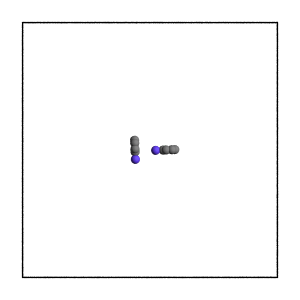

In [102]:
q1 = rotate_quaternion(rotate_quaternion(q=[1, 0, 0, 0], theta=np.pi/2, axis='y'), theta=np.pi/2, axis='x')
q1 = rotate_quaternion(q1, theta=np.pi, axis='y')
q2 = rotate_quaternion([1, 0, 0, 0], theta=np.pi/2, axis='z')
rigid_simulation = create_rigid_simulation(orientations=[q1, q2], positions=rigid_pos,
                                           n_rigids=n_rigids, rel_const_pos=rel_const_pos,
                                          pps_ff=pps_ff)
print('potential_energy: ', rigid_simulation.operations.computes[0].potential_energy)
hoomd.write.GSD.write(rigid_simulation.state, filename="new_snapshots/face-end-s-close.gsd")
# looking down the y axis
sim_viewer = FresnelGSD(gsd_file="new_snapshots/face-end-s-close.gsd", view_axis=(0, 1, 0), frame=-1, height=20,
                       color_dict={"sh": (0.42,0.267,1), "ca":(0.5, 0.5, 0.5), "rigid":(0.1, 0.8, 0.)}
                    )
sim_viewer.view()